In [1]:
import pandas as pd
import os
import numpy as np
import json

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
from sklearn import metrics
import sys
sys.path.insert(0, "/cellarold/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
from sklearn import linear_model
from regressors import stats
import statsmodels.api as sm
import statsmodels.stats.multitest as multi
from scipy.stats import mannwhitneyu
from scipy import stats

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [5]:
from scipy.stats import mannwhitneyu
from scipy import stats
from sklearn import metrics

In [6]:
def fdr(df,p):
    
    '''
    Inputs:
    df: dataframe of p-values
    p: p-value column
    
    '''
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    return(df)


In [7]:
def ppoints(n, a):
    
    '''numpy analogue or `R`'s `ppoints` function
        see details at http://stat.ethz.ch/R-manual/R-patched/library/stats/html/ppoints.html 
        :param n: array type or number'''
    
    try:
        n = np.float(len(n))
    except TypeError:
        n = np.float(n)
    return (np.arange(n) + 1 - a)/(n + 1 - 2*a)

In [8]:
def calculate_ols(df, x, y):
    
    '''
    Inputs:
    df: dataframe of phenotypes
    x: pheno1
    y: pheno2
    '''
    ols = linear_model.LinearRegression()
    df=df[~df[x].isnull()]
    df=df[~df[y].isnull()]
    X=df[x].values.reshape(-1, 1)
    y=df[y].values.reshape(-1, 1)
        
    X = sm.add_constant(X)
    model=sm.OLS(y,X)
    results=model.fit()

    return(results.pvalues[1],results.params[1])

In [9]:
def compile_freq(freq_directory, cohorts):
    
    '''
    freq_directory: directory with frequency files
    cohorts: list of cohorts to compiled frequencies
    '''
    
    compiled_freq=pd.DataFrame()

    for x in cohorts:
        print(x)
        f=pd.read_csv(freq_directory+x+".freq.afreq",delimiter="\t")
        f["study"]=x
        compiled_freq=compiled_freq.append(f)
    
    return(compiled_freq)

def extract_freq(compiled_freq, extract, exclude):
    '''
    compiled_freq: dataframe of compiled_frequencies
    extract: list of snps to extract
    exclude: list of snps to exclude
    '''
    
    freq=compiled_freq[compiled_freq["ID"].isin(extract)]
    freq=freq[~freq["ID"].isin(exclude)]
    
    return(freq)

### ICB mapping

In [10]:
df_mapping=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/wxs_rna_mapping_table_v2.tsv",delimiter="\t")
mp_rna_geno=dict(zip(df_mapping[~df_mapping["tumor RNA id"].isnull()]["tumor RNA id"],df_mapping[~df_mapping["tumor RNA id"].isnull()]["normal WXS id"]))
mp_study=dict(zip(df_mapping['normal WXS id'],df_mapping["study_cancer"]))
mp_sex=dict(zip(df_mapping["normal WXS id"],df_mapping["Gender"]))
mp_age=dict(zip(df_mapping["normal WXS id"],df_mapping["Age"]))

#get phenotype data
pheno=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/phenos/total.pheno.responder.v2.txt",delimiter="\t")
mp_pheno=dict(zip(pheno["FID"],pheno["response_crist_sd"]))

In [11]:
snps=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_3.csv",delimiter="\t")
snps["snp_noallele"]=snps["proxy_variant"].str.rsplit(":",2).str[0]
mp_assoc=dict(zip(snps["snp_noallele"],snps["file"]))

### Extract variants with MAF > 0.05 in discovery cohort

In [12]:
v1_cohorts=["snyder","hugo","riaz","vanallen"]

compiled_freq=compile_freq("/cellar/users/mpagadal/projects/germline-immune/data/icb-response/metal/input/response_crist_sd/",v1_cohorts)
print("{} ICB SNPs available through imputation".format(len(compiled_freq["ID"].unique())))

common_compiled_freq=compiled_freq[compiled_freq["ALT_FREQS"]>0.05] #Trying altered threshold
#common_compiled_freq=compiled_freq[compiled_freq["ALT_FREQS"]>0.25]

print("{} ICB SNPs with MAF > 0.01 available through imputation".format(len(common_compiled_freq["ID"].unique())))

snyder
hugo
riaz
vanallen
39127678 ICB SNPs available through imputation
4489839 ICB SNPs with MAF > 0.01 available through imputation


In [13]:
#compiled_freq

In [14]:
#1084 TIME snps
time_snps=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/snp-tables/extract-all-time-variants-proxy.txt",header=None)[0].tolist()
exclude=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/snp-tables/exclude-high-mismatch-icb-snps.txt",header=None)[0].tolist()
exclude=exclude+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in exclude]

time_freq=extract_freq(common_compiled_freq,time_snps,exclude)
counts=time_freq["ID"].value_counts().reset_index()
print("{} snps with MAF > 0.05 in all studies".format(len(counts[counts["ID"]>(len(v1_cohorts)-1)])))

#extract variants with MAF > 0.05 in all studies
icb_snps=counts[counts["ID"]>(len(v1_cohorts)-1)]["index"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in counts[counts["ID"]>(len(v1_cohorts)-1)]["index"].tolist()]
icb_snps=pd.DataFrame({"snps":icb_snps})

562 snps with MAF > 0.05 in all studies


In [15]:
#get high imputed snps
info=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/icb-geno-qc/compiled.info",delimiter="\t")
high_impute_info=info[info["Rsq"]>0.3]
high_imputed_snps=high_impute_info["SNP"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in high_impute_info["SNP"].tolist()]

In [16]:
dict_freq=compiled_freq[["ID","ALT_FREQS"]].groupby("ID").mean()
mp_freq=dict(zip(dict_freq.index,dict_freq["ALT_FREQS"]))

### META-ANALYSIS of ICB response in 6 ICB studies

### Get agnostic analysis

(525, 7)


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


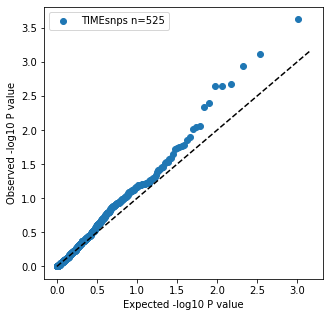

In [17]:
#get metal analysis results
sd_metal=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/icb-response/metal/output/response_crist_sd/v1.effect/METAANALYSIS1.TBL",delimiter="\t")
sd_metal=sd_metal[sd_metal["MarkerName"].isin(icb_snps["snps"].tolist())] #keep snps with MAF > 0.05 in all cohorts
sd_metal=sd_metal[sd_metal["MarkerName"].isin(high_imputed_snps)] #include high confidence snps only
print(sd_metal.shape)
sd_metal=fdr(sd_metal,"P-value")

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

p_values=sd_metal.sort_values(by="P-value")["P-value"].tolist()
plt.scatter(-np.log10(ppoints(len(p_values), 1./2)), -np.log10(p_values),label="TIMEsnps n="+str(len(p_values)))

ax.plot([0,ax.get_xlim()[1]], [0,ax.get_xlim()[1]], ls="--", c="k")
ax.set_xlabel("Expected -log10 P value")
ax.set_ylabel("Observed -log10 P value")
plt.legend()
# plt.savefig("../plots/fig6/icb.qq.pdf")

In [18]:
#plot histogram

In [19]:
sd_metal["snp_noallele"]=sd_metal["MarkerName"].str.rsplit(":",2).str[0]
sd_metal["freq"]=sd_metal["MarkerName"].map(mp_freq)
sd_metal["file"]=sd_metal["snp_noallele"].map(mp_assoc)

In [20]:
#sd_metal.to_csv("/cellar/users/tsears/projects/germline-immune/data/supplemental/Supplemental_Table_8_MAF_0.1.csv",index=None)

### Create burden score with SNPs in other cohort

In [21]:
import scipy.stats as stats
random_state=10

In [22]:
def make_burden(raw, snps, mp_alleles):
    #get raw ICB genotypes
    raw=pd.read_csv(raw,delim_whitespace=True)
    raw=raw.set_index("FID")
    raw=raw.iloc[:,5:]
    
    snps=pd.DataFrame({"ID":snps})
    snps["A1"]=snps["ID"].map(mp_alleles)
    print("constructing burden from {} snps".format(len(snps)))
    
    burden_snps=[]

    # Iterate through ICB associated snps

    
    for i,row in snps.iterrows():
        
        mp={0:2,1:1,2:0}
        
        snp_all=[x for x in raw.columns if row["ID"] in x]
        
        if len(snp_all) == 0:
            continue
            
        snp=snp_all[0]
        
        min_allele=snp.split("_")[1]
        if min_allele != row["A1"]: #switching genotype if minor alleles are not aligned
            #print("switching genotype {}".format(snp))
            raw[snp]=raw[snp].map(mp)
        
        burden_snps.append(snp)
    
    #make burden score
    raw_burden=raw[burden_snps]
    raw_burden["score"]=raw_burden.sum(axis=1) 
    raw_burden["burden"]=raw_burden["score"]/(len(burden_snps)*2)
    
    return(raw_burden)

### pvalue 0.05

In [23]:
sd_metal_sig=sd_metal[sd_metal["P-value"]<0.05]
#sd_metal_sig=sd_metal#[sd_metal["P-value"]<.05]
sd_metal_sig.sort_values(by=["MarkerName","file"])
snps_sig=pd.merge(snps,sd_metal_sig,left_on="snp_noallele",right_on="snp_noallele")
#snps_sig.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig6/rsid_snp_list.txt",sep='\t')


In [24]:
mp_alleles={}

for i,row in sd_metal_sig.iterrows():
    count=0
    for sign in row["Direction"]:
        if sign == "+":
            count+=1
    if count > 2:
        mp_alleles[row["MarkerName"]]=row["Allele1"].upper()
    else:
        mp_alleles[row["MarkerName"]]=row["Allele2"].upper()
        

In [25]:
#save sig_burden object for reloading!!!!
#sig_burden.to_csv("/cellar/users/tsears/projects/germline-immune/data/sig_burden_filt.csv")
#sig_burden=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/sig_burden_filt.csv")

In [26]:
sig_burden=make_burden("/cellar/users/mpagadal/projects/germline-immune/data/icb-genotypes/all.time.raw",sd_metal_sig["MarkerName"].tolist(),mp_alleles)
sig_burden["study"]=sig_burden.index.map(mp_study)
sig_burden["pheno"]=sig_burden.index.map(mp_pheno)
sig_burden=sig_burden[~sig_burden["pheno"].isnull()]

constructing burden from 32 snps


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
import sklearn.preprocessing

#Map beta values from crist study onto SNPs if applicable

#read in beta_table
beta_table=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/icb-response/prsice-associations/response_crist_sd.prsice.response_crist_sd.glm.logistic.hybrid",delimiter='\t')
#trim beta table to only ADD
beta_table=beta_table[beta_table["TEST"]=="ADD"]
#adjust mapping colname
s=beta_table["ID"].str.rsplit(":",2)
sm = np.array(s.tolist())
sm_chars=sm[:,2]

beta_table["proxy_variant_chars"]=beta_table["ID"]+"_"+sm_chars

print(beta_table["OR"])
#multiply snp_sig beta value on each matching SNP column

for i in beta_table["proxy_variant_chars"]:
    if i in sig_burden:
        sig_burden[i]=sig_burden[i]*float(beta_table.loc[beta_table["proxy_variant_chars"]==i,"OR"])
        

0        0.611539
16       0.837965
32       0.853910
48       0.854469
64       0.878862
           ...   
15888    0.868421
15904    0.969559
15920    1.150240
15936         NaN
15952    1.350320
Name: OR, Length: 998, dtype: float64


In [28]:
from sklearn.model_selection import train_test_split

sig_burden_LASSO_training=sig_burden[sig_burden["study"].isin(["vanallen","hugo","riaz","snyder"])]
sig_burden_LASSO_testing=sig_burden[sig_burden["study"].isin(["miao","rizvi"])]


sig_burden_LASSO_training_x=sig_burden_LASSO_training.drop(['score', 'burden','study','pheno'], axis=1)

sig_burden_LASSO_training_y=sig_burden_LASSO_training['pheno']

sig_burden_LASSO_testing_x=sig_burden_LASSO_testing.drop(['score', 'burden','study','pheno'], axis=1)

sig_burden_LASSO_testing_y=sig_burden_LASSO_testing['pheno']

0.8428495481127061


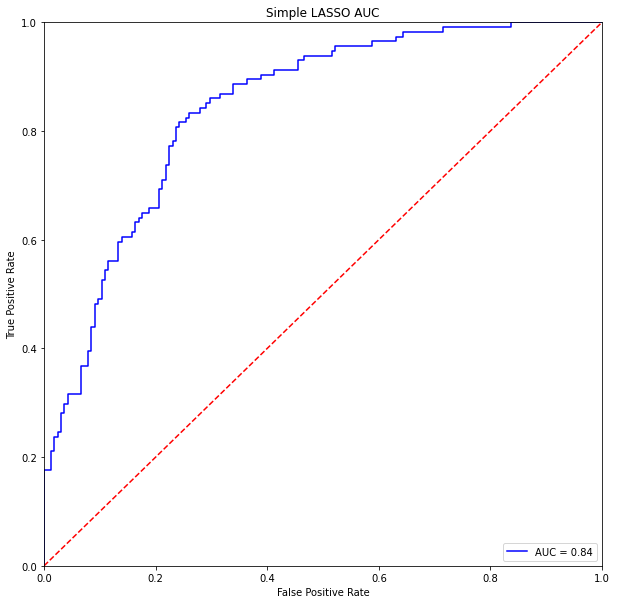

['16:23458272:T:C_C']


In [29]:
#filter using LASSO regression
from sklearn.linear_model import Lasso

# define model
model = Lasso(alpha=0.001,random_state=random_state)
# fit model
model.fit(sig_burden_LASSO_training_x, sig_burden_LASSO_training_y)
p = model.predict(sig_burden_LASSO_training_x)  # test the output by changing values

#Find model that gives best AUC, do a cutoff of weakest contributing SNPS, then run all analysis portions

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
#preds = np.around(p, decimals=0, out=None)

preds=p

fpr, tpr, threshold = metrics.roc_curve(list(sig_burden_LASSO_training_y), preds,pos_label=2)
roc_auc = metrics.auc(fpr, tpr)

print(roc_auc)
# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Simple LASSO AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#now drop SNPs with low contribution
print(sig_burden_LASSO_training_x.columns.values[model.coef_==0])


In [30]:
sig_burden_dropped=sig_burden.drop(sig_burden_LASSO_training_x.columns.values[model.coef_==0],axis=1)

In [31]:
#pd.DataFrame(sig_burden_dropped.columns.values).to_csv("/cellar/users/tsears/projects/germline-immune/data/fig6/icb_final_snps.txt",sep="\t")

In [32]:
sig_burden_LASSO_training_dropped=sig_burden_dropped[sig_burden_dropped["study"].isin(["vanallen","hugo","riaz","snyder"])]
sig_burden_LASSO_testing_dropped=sig_burden_dropped[sig_burden_dropped["study"].isin(["miao","rizvi"])]

sig_burden_LASSO_training_x_dropped=sig_burden_LASSO_training_dropped.drop(['score', 'burden','study','pheno'], axis=1)
sig_burden_LASSO_training_y_dropped=sig_burden_LASSO_training_dropped['pheno']

sig_burden_LASSO_testing_x_dropped=sig_burden_LASSO_testing_dropped.drop(['score', 'burden','study','pheno'], axis=1)
sig_burden_LASSO_testing_y_dropped=sig_burden_LASSO_testing_dropped['pheno']

In [38]:
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

regressor_xgb = xgboost.XGBRFRegressor(n_estimators =500, random_state = random_state,learning_rate=0.1,max_depth=9)
#regressor_xgb=xgboost.XGBRFRegressor(n_estimators = 200, random_state = random_state,learning_rate=0.3,max_depth=9)
regressor_xgb.fit(sig_burden_LASSO_training_x_dropped, sig_burden_LASSO_training_y_dropped)  

p = regressor_xgb.predict(sig_burden_LASSO_testing_x_dropped)  # test the output by changing values
p_disc=regressor_xgb.predict(sig_burden_LASSO_training_x_dropped)

sig_burden_LASSO_testing_dropped["LASSO_burden"]=p
sig_burden_LASSO_training_dropped["LASSO_burden"]=p_disc

#export the training and testing models
#sig_burden_LASSO_testing_dropped.to_csv("/cellar/users/tsears/projects/germline-immune/data/sig_burden_LASSO_testing.csv")
#sig_burden_LASSO_training_dropped.to_csv("/cellar/users/tsears/projects/germline-immune/data/sig_burden_LASSO_training.csv")


# define model evaluation method
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
#scores = cross_val_score(model, sig_burden_LASSO_training_x, sig_burden_LASSO_training_y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
#scores = absolute(scores)
#print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

#model.predict(sig_burden_LASSO_testing_x)

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(array([0, 1]), [Text(0, 0, '1.0'), Text(1, 0, '2.0')])

<Figure size 360x360 with 0 Axes>

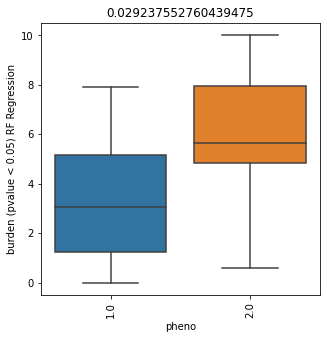

In [41]:
fig = plt.figure(figsize=(5,5))
validation=sig_burden_LASSO_testing_dropped[sig_burden_LASSO_testing_dropped["study"]=="rizvi"]

validation_plot=validation
minmax_scale = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 10))
x = validation_plot["LASSO_burden"].values.reshape(-1, 1)
validation_plot["LASSO_scaled"] = minmax_scale.fit_transform(x)

fig = plt.figure(figsize=(5,5))

sns.boxplot(x="pheno",y="LASSO_scaled",data=validation_plot)

cat1 = validation[validation["pheno"]==1]
cat2 = validation[validation["pheno"]==2]
rizvi_score=cat2["LASSO_burden"].mean()-cat1["LASSO_burden"].mean()

plt.title(stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

plt.ylabel("burden (pvalue < 0.05) RF Regression")
plt.xticks(rotation=90)
#plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/rizvi_LASSO_PRS_scaled.pdf")

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(array([0, 1]), [Text(0, 0, '1.0'), Text(1, 0, '2.0')])

<Figure size 360x360 with 0 Axes>

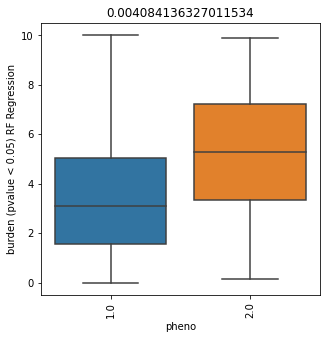

In [42]:
fig = plt.figure(figsize=(5,5))
validation=sig_burden_LASSO_testing_dropped[sig_burden_LASSO_testing_dropped["study"]=="miao"]

validation_plot=validation
minmax_scale = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 10))
x = validation_plot["LASSO_burden"].values.reshape(-1, 1)
validation_plot["LASSO_scaled"] = minmax_scale.fit_transform(x)

fig = plt.figure(figsize=(5,5))

sns.boxplot(x="pheno",y="LASSO_scaled",data=validation_plot)

cat1 = validation[validation["pheno"]==1]
cat2 = validation[validation["pheno"]==2]
miao_score=cat2["LASSO_burden"].mean()-cat1["LASSO_burden"].mean()

plt.title(stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

plt.ylabel("burden (pvalue < 0.05) RF Regression")
plt.xticks(rotation=90)
#plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/miao_LASSO_PRS_scaled.pdf")

In [ ]:
features = sig_burden_LASSO_testing_x_dropped.columns.values.tolist()
features=[x.rsplit("_")[0] for x in features]
importances = regressor_xgb.feature_importances_

mapping_table=pd.concat([pd.DataFrame(features),pd.DataFrame(importances)],axis=1)
mapping_table.columns=["ID","importance"]

rsid_table=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_3_annot.csv",sep="\t")
rsid_table=rsid_table.drop_duplicates(subset="rsid")
rsid_table=rsid_table[["snps","rsid"]]

mapping_table["ID2"]=[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in mapping_table["ID"].tolist()]

compiled_icb_rsid=pd.merge(mapping_table,rsid_table,left_on="ID",right_on="snps")
compiled_icb_rsid2=pd.merge(mapping_table,rsid_table,left_on="ID2",right_on="snps")

compiled_icb_rsid_plot=pd.concat([compiled_icb_rsid,compiled_icb_rsid2],axis=0)
compiled_icb_rsid_plot=compiled_icb_rsid_plot.sort_values(by="importance")
compiled_icb_rsid_plot_snps=compiled_icb_rsid_plot["snps"]
compiled_icb_rsid_plot_snps=pd.DataFrame(compiled_icb_rsid_plot_snps.tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in compiled_icb_rsid_plot_snps.tolist()])
#compiled_icb_rsid_plot_snps.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig6/top_icb_snps_fwd_rev.txt",sep="\t",header=False,index=False)
#compiled_icb_rsid_plot.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig6/icb_featureImportance.txt",sep="\t")
compiled_icb_rsid_plot=compiled_icb_rsid_plot.iloc[compiled_icb_rsid_plot.shape[0]-15:compiled_icb_rsid_plot.shape[0],:]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


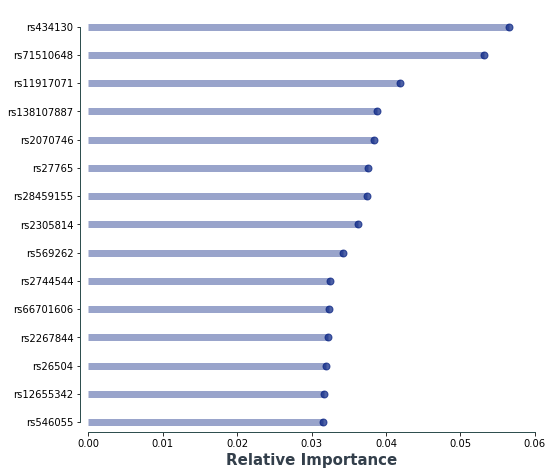

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='darkslategrey'
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.style.use('seaborn-dark-palette')

my_range=list(range(0,len(compiled_icb_rsid_plot["importance"])))
fig, ax = plt.subplots(figsize=(8,8))
plt.hlines(y=my_range, xmin=0, xmax=compiled_icb_rsid_plot["importance"], alpha=0.4, linewidth=7)
plt.plot(compiled_icb_rsid_plot["importance"], my_range, "o", markersize=7, alpha=0.7)
# set labels style
ax.set_xlabel('Relative Importance', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds((0, len(my_range)-1))
ax.set_xlim(0,0.06)
plt.yticks(range(len(compiled_icb_rsid_plot["importance"])), compiled_icb_rsid_plot["rsid"])
# add some space between the axis and the plot
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', -10))

#plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/feature_importance_V2.pdf",bbox_inches = "tight")

#write out snps of top hits for supplemental CTSS analysis

In [62]:
from sklearn.datasets import load_boston
from sklearn.model_selection import timportance_type=split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

In [ ]:
#perm_importance = permutation_importance(regressor_xgb, sig_burden_LASSO_testing_x, sig_burden_LASSO_testing_y)

In [ ]:
def correlation_heatmap(train,figtype):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/discovery_SNP_correlation_"+figtype+".pdf")

    plt.show();
    
correlation_heatmap(sig_burden_LASSO_training_x.reindex(sorted(sig_burden_LASSO_training_x.columns), axis=1),"discovery")
#DISCOVERY COHORTS


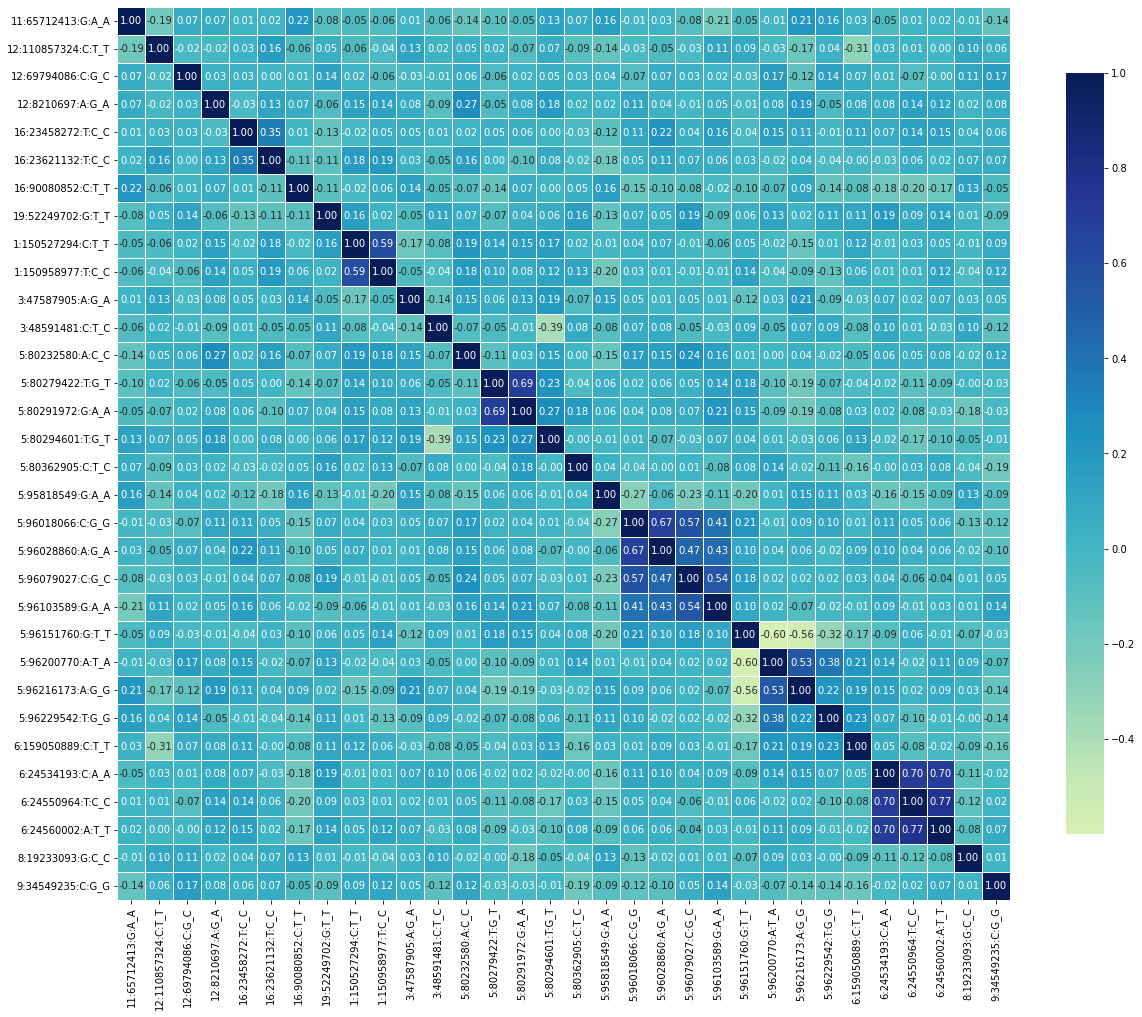

In [97]:
correlation_heatmap(sig_burden_LASSO_testing_x.reindex(sorted(sig_burden_LASSO_testing_x.columns), axis=1),"validation")
#Validation Cohorts


In [98]:
#Now perform AUC plots using my approach with some kind of optimal cutoff maybe.
#incorporate covariates into AUC plot?

In [ ]:
validation_miao=sig_burden_LASSO_testing_dropped[sig_burden_LASSO_testing_dropped["study"]=="miao"]
validation_rizvi=sig_burden_LASSO_testing_dropped[sig_burden_LASSO_testing_dropped["study"]=="rizvi"]

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
#preds = np.around(p, decimals=0, out=None)

preds=p

fpr, tpr, threshold = metrics.roc_curve(validation_miao["pheno"],validation_miao["LASSO_burden"],pos_label=2)
roc_auc = metrics.auc(fpr, tpr)

fpr1, tpr1, threshold1 = metrics.roc_curve(validation_rizvi["pheno"],validation_rizvi["LASSO_burden"],pos_label=2)
roc_auc1 = metrics.auc(fpr1, tpr1)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'Miao AUC = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'b', label = 'Rizvi AUC = %0.2f' % roc_auc1,color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/validation_auc_plot.pdf")
plt.show()


In [ ]:
#Now we have to prove that a random list of SNPs selected from the TIME list / big list does not outperform list generated from pvalue cutoff

### Take random TIME snps

In [122]:
#Should background selection be done on ALL different genes or ALL different SNPs?
sd_time_metal_sample=sd_metal[~sd_metal["file"].isin(sd_metal_sig["file"].tolist())]

raw=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/icb-genotypes/all.time.raw",delim_whitespace=True,nrows=0)
snps=[x.split("_")[0] for x in raw.columns[6:]]
snps=snps+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in snps]
sd_time_metal_sample=sd_time_metal_sample[sd_time_metal_sample["MarkerName"].isin(snps)]

In [123]:
len(sd_time_metal_sample["MarkerName"].unique())

206

In [325]:
#Generate model and run it over 100 times


import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

disc_mean_list=[]
miao_mean_list=[]
rizvi_mean_list=[]

for num in range(1):
    
    if num % 10 ==0:
        print("{} iterations done".format(num))
    
    #get random subset of sd_time_metal_sample
    sd_time_metal_sample_subset=sd_time_metal_sample.sample(n=sd_metal_sig.shape[0])
    
    #get mp_alleles object
    mp_alleles={}

    for i,row in sd_time_metal_sample_subset.iterrows():
        count=0
        for sign in row["Direction"]:
            if sign == "+":
                count+=1
        if count > 2:
            mp_alleles[row["MarkerName"]]=row["Allele1"].upper()
        else:
            mp_alleles[row["MarkerName"]]=row["Allele2"].upper()
        
    #make burden of subset in correct format
    sig_burden_sample=make_burden("/cellar/users/mpagadal/projects/germline-immune/data/icb-genotypes/all.time.raw",sd_time_metal_sample_subset["MarkerName"].tolist(),mp_alleles)
    sig_burden_sample["study"]=sig_burden_sample.index.map(mp_study)
    sig_burden_sample["pheno"]=sig_burden_sample.index.map(mp_pheno)
    sig_burden_sample=sig_burden_sample[~sig_burden_sample["pheno"].isnull()]
    
    
    #Generate dataset split and run model
    sig_burden_LASSO_training=sig_burden_sample[sig_burden_sample["study"].isin(["vanallen","hugo","riaz","snyder"])]
    sig_burden_LASSO_testing=sig_burden_sample[sig_burden_sample["study"].isin(["miao","rizvi"])]

    sig_burden_LASSO_training_x=sig_burden_LASSO_training.drop(['score', 'burden','study','pheno'], axis=1)
    sig_burden_LASSO_training_y=sig_burden_LASSO_training['pheno']

    sig_burden_LASSO_testing_x=sig_burden_LASSO_testing.drop(['score', 'burden','study','pheno'], axis=1)
    sig_burden_LASSO_testing_y=sig_burden_LASSO_testing['pheno']


    regressor_xgb = xgboost.XGBRFRegressor(n_estimators = 500, random_state = 10,learning_rate=0.1,max_depth=9) 
    regressor_xgb.fit(sig_burden_LASSO_training_x, sig_burden_LASSO_training_y)   

    p = regressor_xgb.predict(sig_burden_LASSO_testing_x)  # test the output by changing values
    p_disc=regressor_xgb.predict(sig_burden_LASSO_training_x)

    sig_burden_LASSO_testing["LASSO_burden"]=p
    sig_burden_LASSO_training["LASSO_burden"]=p_disc


    miao1 = p[np.logical_and(sig_burden_LASSO_testing["study"]=="miao",sig_burden_LASSO_testing["pheno"]==1)]
    miao2 = p[np.logical_and(sig_burden_LASSO_testing["study"]=="miao",sig_burden_LASSO_testing["pheno"]==2)]
    miao_mean_list.append(miao2.mean()-miao1.mean())
    
    rizvi1 = p[np.logical_and(sig_burden_LASSO_testing["study"]=="rizvi",sig_burden_LASSO_testing["pheno"]==1)]
    rizvi2 = p[np.logical_and(sig_burden_LASSO_testing["study"]=="rizvi",sig_burden_LASSO_testing["pheno"]==2)]
    rizvi_mean_list.append(rizvi2.mean()-rizvi1.mean())
    
    disc1 = p_disc[sig_burden_LASSO_training["pheno"]==1]
    disc2 = p_disc[sig_burden_LASSO_training["pheno"]==2]
    disc_mean_list.append(disc2.mean()-disc1.mean())
    



0 iterations done
constructing burden from 32 snps


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

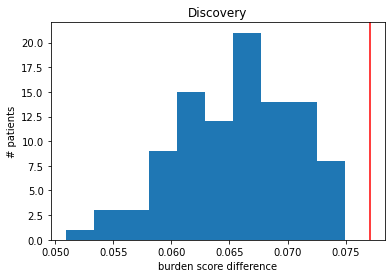

In [125]:
plt.hist(disc_mean_list)
plt.axvline(disc_score,color="red")
plt.xlabel("burden score difference")
plt.ylabel("# patients")
plt.title("Discovery")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/GENE_method_discovery.bootstrapping.pdf")

0.0


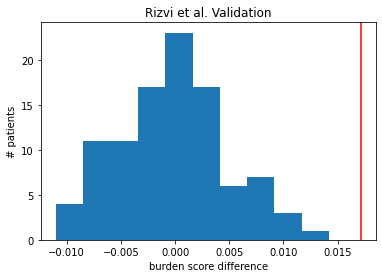

In [126]:
plt.hist(rizvi_mean_list)
truth=rizvi_score
plt.axvline(truth,color="red")
plt.xlabel("burden score difference")
plt.ylabel("# patients")
plt.title("Rizvi et al. Validation")
print(len([x for x in rizvi_mean_list if x > truth])/len(rizvi_mean_list))
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/GENE_method_rizvi.bootstrapping.pdf")

0.0


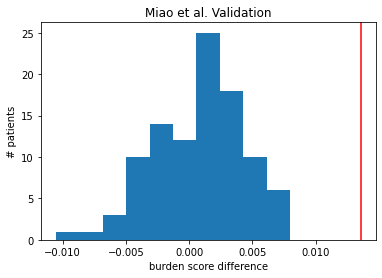

In [127]:
plt.hist(miao_mean_list)
truth=miao_score
plt.axvline(truth,color="red")
plt.xlabel("burden score difference")
plt.ylabel("# patients")
plt.title("Miao et al. Validation")
print(len([x for x in miao_mean_list if x > truth])/len(miao_mean_list))
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/GENE_method_miao.bootstrapping.pdf")

### PCA plotting

In [228]:
sd_metal_sig_dropped=sd_metal_sig[sd_metal_sig["MarkerName"]!="16:23458272:T:C"]
sd_metal_sig_dropped.shape

(31, 12)

In [229]:
extract=sd_metal_sig_dropped["MarkerName"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in sd_metal_sig["MarkerName"].tolist()]
pd.DataFrame({"snps":extract}).to_csv("/cellar/users/tsears/projects/germline-immune/data/snp-tables/extract.icd.sd.lasso_pval0.05.txt",header=None,index=None,sep="\t")

In [256]:
pca=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/icb-geno-qc/pca/icb-time/pcs.txt",delimiter="\t")
mp_study=mp_study=dict(zip(mapping["normal WXS id"],mapping["study"]))
pca["study"]=pca["IID"].map(mp_study)

In [262]:
pca["study"].value_counts()

liu         115
riaz         52
vanallen     40
miao         33
hugo         27
Name: study, dtype: int64

In [250]:
pca=pca[pca["study"].isin(["hugo","vanallen","miao","riaz","rizvi","snyder"])]

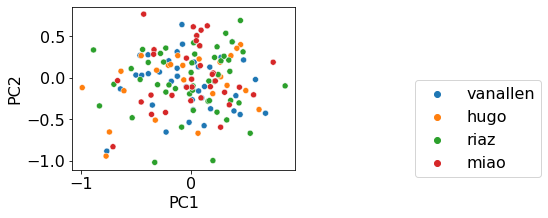

In [251]:
fig = plt.figure(figsize=(4,3))
sns.scatterplot(x="PC1",y="PC2",hue="study",data=pca)
plt.legend(bbox_to_anchor=(1.5,.6))
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig7/icb.geno.pca.pdf")

In [207]:
loadings=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/icb-geno-qc/pca/icb-time/loadings.txt",delimiter="\t")

In [208]:
pca

,FID,IID,PC1,PC2,PC3,study


In [209]:
icb_snps=[x for x in loadings.sort_values(by="V1")["SNP"].tolist() if "3:" in x]

In [210]:
# # sig_burden=make_burden("../data/icb-genotypes/all.time.raw",icb_snps,mp_alleles)
# sig_burden["study"]=sig_burden.index.map(mp_study)
# sig_burden["pheno"]=sig_burden.index.map(mp_pheno)

In [211]:
# fig = plt.figure(figsize=(5,5))
# sns.boxplot(x="study",y="burden",hue="pheno",data=sig_burden)

# cat1 = sig_burden[sig_burden["pheno"]==1]
# cat2 = sig_burden[sig_burden["pheno"]==2]
# plt.title(mannwhitneyu(cat1["burden"], cat2["burden"])[1])

# plt.ylabel("burden (fdr < 0.5)")
# plt.xticks(rotation=90)

### get pseudo r2 for patients

### Check effects of variants

In [36]:
def fdr2(df,p):
    
    '''
    Inputs:
    df: dataframe of p-values
    p: p-value column
    
    '''
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    return(df)


In [37]:
sd_metal_sig_dropped=sd_metal_sig.drop(sd_metal_sig[sd_metal_sig["MarkerName"]=="16:23458272:T:C"].index) #this is the snp that has been dropped in the final model
extract=sd_metal_sig_dropped["MarkerName"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in sd_metal_sig_dropped["MarkerName"].tolist()]

#pd.DataFrame({"snps":extract}).to_csv("/cellar/users/tsears/projects/germline-immune/data/snp-tables/extract.icd.sd.lasso_pval0.05.txt",header=None,index=None,sep="\t")

assoc_dir="/cellar/users/mpagadal/projects/germline-immune/data/icb-response/metal/input/response_crist_sd/"

compiled_icb=pd.DataFrame()

for file in [x for x in os.listdir(assoc_dir) if "add" in x]:
    print(file)
    icb=pd.read_csv(assoc_dir+file,delimiter="\t")
    icb=icb[icb["ID"].isin(extract)]
    icb=fdr2(df=icb,p="P")
    icb["file"]=file
    compiled_icb=compiled_icb.append(icb)
    

vanallen.assoc.logistic.add
crist_hnscc.assoc.logistic.add
hugo.assoc.logistic.add
liu.assoc.logistic.add
riaz.assoc.logistic.add
crist_melanoma.assoc.logistic.add
snyder.assoc.logistic.add
rizvi.assoc.logistic.add
miao.assoc.logistic.add


In [38]:
compiled_icb["log(OR)"]=np.log10(compiled_icb["OR"])

In [39]:
compiled_icb["file"]=compiled_icb["file"].str.split(".").str[0]

In [40]:
compiled_icb=compiled_icb[compiled_icb["file"].isin(["vanallen","snyder","rizvi","riaz","hugo","miao"])]

In [41]:
compiled_icb=compiled_icb.sort_values(by=["#CHROM","file"])

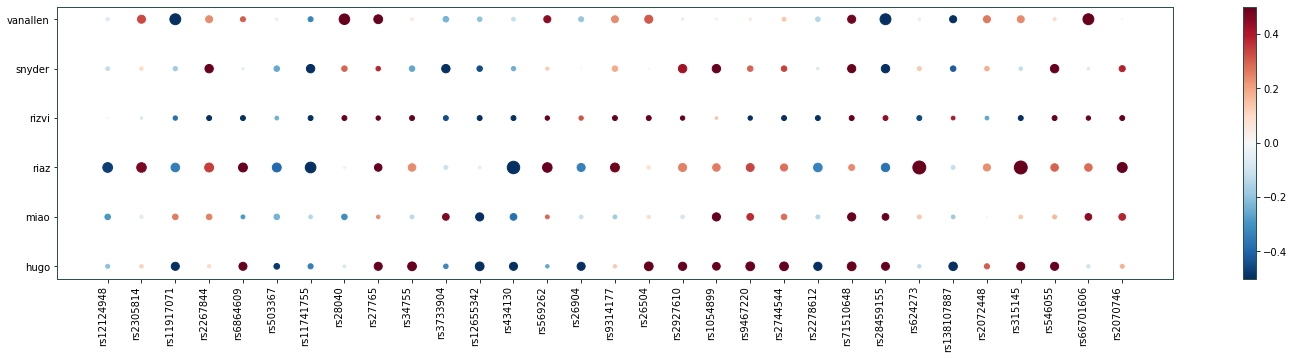

In [209]:
#Plot

def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(25, 5))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 100
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-.5, vmax=.5# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
rsid_table=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_3_annot.csv",sep="\t")
rsid_table=rsid_table.drop_duplicates(subset="rsid")
rsid_table=rsid_table[["snps","rsid"]]

compiled_icb["ID2"]=[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in compiled_icb["ID"].tolist()]

compiled_icb_rsid=pd.merge(compiled_icb,rsid_table,left_on="ID",right_on="snps")
compiled_icb_rsid2=pd.merge(compiled_icb,rsid_table,left_on="ID2",right_on="snps")

compiled_icb_rsid_plot=pd.concat([compiled_icb_rsid,compiled_icb_rsid2],axis=0)
compiled_icb_rsid_plot=compiled_icb_rsid_plot.sort_values(by=["#CHROM","file"])

heatmap(
    x=compiled_icb_rsid_plot['rsid'],
    y=compiled_icb_rsid_plot['file'],
    size=compiled_icb_rsid_plot['-log10(fdr)'],
    color=compiled_icb_rsid_plot['log(OR)'],
)
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/study.icb.clustermap.pdf")

In [210]:
compiled_icb_size=compiled_icb.copy()

In [211]:
compiled_icb_size['-log10(fdr)']=np.where(compiled_icb_size["ID"]=="1:150958977:T:C",2,compiled_icb_size['-log10(fdr)'])
compiled_icb_size['-log10(fdr)']=np.where(compiled_icb_size["ID"]=="3:47587905:A:G",1.33,compiled_icb_size['-log10(fdr)'])
compiled_icb_size['-log10(fdr)']=np.where(compiled_icb_size["ID"]=="3:48591481:C:T",1,compiled_icb_size['-log10(fdr)'])
compiled_icb_size["ID2"]=[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in compiled_icb_size["ID"].tolist()]

rsid_table=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_3_annot.csv",sep="\t")
rsid_table=rsid_table.drop_duplicates(subset="rsid")
rsid_table=rsid_table[["snps","rsid"]]

compiled_icb_size_rsid=pd.merge(compiled_icb_size,rsid_table,left_on="ID",right_on="snps")
compiled_icb_size_rsid2=pd.merge(compiled_icb_size,rsid_table,left_on="ID2",right_on="snps")

compiled_icb_size_rsid_plot=pd.concat([compiled_icb_size_rsid,compiled_icb_size_rsid2],axis=0)
compiled_icb_size_rsid_plot=compiled_icb_size_rsid_plot.sort_values(by=["#CHROM","file"])
compiled_icb_size_rsid_plot.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig6/ICB_OS_Heatmap_plotting_df.txt",sep="\t")

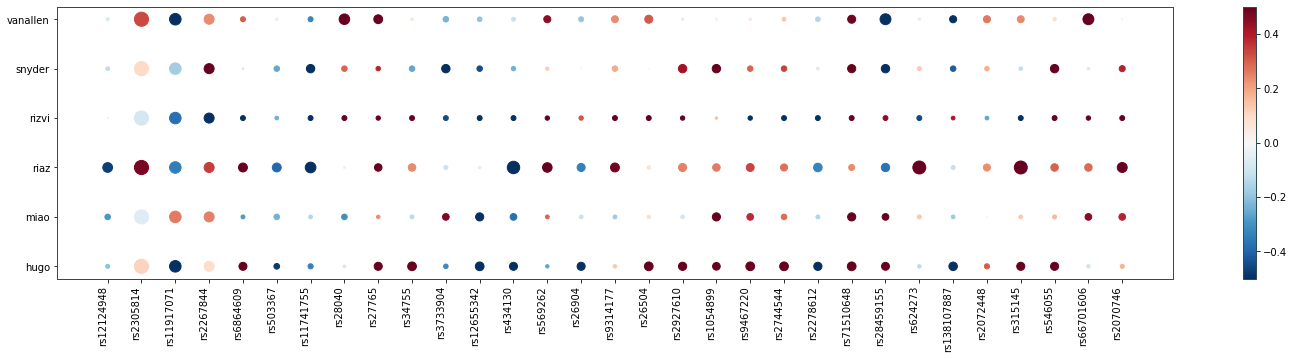

In [212]:
heatmap(
    x=compiled_icb_size_rsid_plot['rsid'],
    y=compiled_icb_size_rsid_plot['file'],
    size=compiled_icb_size_rsid_plot['-log10(fdr)'],
    color=compiled_icb_size_rsid_plot['log(OR)'])
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/study.icb.size.clustermap.pdf")

In [46]:
compiled_icb_size[compiled_icb_size["fdr"]<=0.05]

,#CHROM,POS,ID,REF,ALT,A1,FIRTH?,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,ERRCODE,fdr,-log10(fdr),file,log(OR),ID2
13200477,5,80279422,5:80279422:T:G,G,T,T,N,ADD,67,0.159213,0.613665,-2.99433,0.002751,.,0.028422,1.546346,riaz,-0.798021,5:80279422:G:T
26195478,11,65712413,11:65712413:G:A,G,A,A,N,ADD,67,5.299190,0.513710,3.24610,0.001170,.,0.021314,1.671343,riaz,0.724209,11:65712413:A:G
28149318,12,69794086,12:69794086:C:G,G,C,C,N,ADD,67,5.587290,0.537682,3.19983,0.001375,.,0.021314,1.671343,riaz,0.747201,12:69794086:G:C


### Check MAF of variants

In [293]:
v1_cohorts=["snyder","hugo","riaz","vanallen","rizvi","miao"]

compiled_freq=compile_freq("/cellar/users/mpagadal/projects/germline-immune/data/icb-response/metal/input/response_crist_sd/",v1_cohorts)

print("{} ICB SNPs available through imputation".format(len(compiled_freq["ID"].unique())))

snyder
hugo
riaz
vanallen
rizvi
miao
39127678 ICB SNPs available through imputation


In [294]:
len(time_snps)

2168

In [295]:
compiled_icb_freq=compiled_freq[compiled_freq["ID"].isin(time_snps)]

In [296]:
compiled_icb_freq.shape


(5928, 7)

In [297]:
compiled_icb_freq=compiled_icb_freq[compiled_icb_freq.ID.isin(sd_metal_sig.sort_values(by="MarkerName")["MarkerName"].tolist())]
compiled_icb_freq

,#CHROM,ID,REF,ALT,ALT_FREQS,OBS_CT,study
1684596,1,1:150527294:C:T,C,T,0.398438,128,snyder
1689239,1,1:150958977:T:C,T,C,0.445312,128,snyder
7193738,3,3:47587905:A:G,G,A,0.320312,128,snyder
7204742,3,3:48591481:C:T,T,C,0.437500,128,snyder
13199779,5,5:80232580:A:C,A,C,0.062500,128,snyder
...,...,...,...,...,...,...,...
28709312,12,12:110857324:C:T,C,T,0.121429,140,miao
33245404,16,16:23458272:T:C,T,C,0.064286,140,miao
33247423,16,16:23621132:T:C,T,C,0.314286,140,miao
34121881,16,16:90080852:C:T,C,T,0.242857,140,miao


In [298]:
df_freq=pd.merge(compiled_icb_freq[["ID","ALT_FREQS"]].groupby("ID").mean(),compiled_icb_freq[["ID","ALT_FREQS"]].groupby("ID").std(),right_index=True,left_index=True)


In [299]:
df_freq.columns=["mean","std"]

In [300]:
df_freq["chr"]=df_freq.index.str.split(":").str[0]

In [301]:
df_freq["chr"]=df_freq["chr"].astype(int)

In [302]:
df_freq=df_freq.sort_values(by="chr")

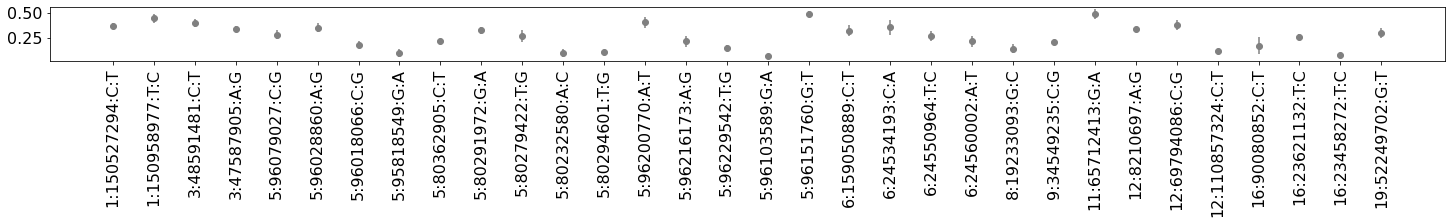

In [303]:
fig = plt.figure(figsize=(25,1))
plt.errorbar(x=df_freq.index.tolist(),y=df_freq["mean"].tolist(),yerr=df_freq["std"].tolist(),fmt="o",color="gray")
plt.xticks(rotation=90)
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig7/maf.error.pdf")

### TMB analysis of other cohorts: TMB vs germline PRS variance explained, TMB vs germline PRS AUC. TMB+germline PRS AUC?

In [101]:
import pandas as pd
import json
import os
import numpy as np

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text

In [103]:
#OLS analysis
from sklearn import linear_model
from regressors import stats
import statsmodels.api as sm

In [104]:
from scipy.stats import mannwhitneyu
from scipy import stats

In [105]:
import statsmodels.stats.multitest as multi

In [106]:
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [107]:
with open('/cellar/controlled/dbgap-genetic/ICB/rna/TPMs/all_immunotherapy_tpm.json', 'r') as f:
    icb_tpm = json.load(f)
tpm=pd.DataFrame.from_dict(icb_tpm)

In [108]:
def fdr(df,pseudo,p):
    
    '''
    calculate Benjamini-Hochberg FDR
    pseudo: True or False
    '''
    
    #add pseudocounta
    if pseudo == True:
        df[p]=df[p]+0.000000000001
    
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

### Get PD-1/PD-L1

In [109]:
#analyze TPM rna
rna=tpm.copy()
rna+=1
rna=np.log2(rna)

In [110]:
rna.index=rna.index.str.split(".").str[0]
rna["gene name"]=rna.index.map(ensembl)
rna=rna[~(rna["gene name"].isnull())]
rna.index=rna["gene name"]
del rna["gene name"]
rna=rna.T
rna.index=rna.index.str.split(".sra").str[0]
rna=rna.reset_index()
rna=rna.rename(columns={"index":"FID"})

In [111]:
#get mapping file
mapping=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/wxs_rna_mapping_table_v2.tsv",delimiter="\t")
print(len(mapping["normal WXS id"].unique()))
mapping=mapping[~(mapping["tumor RNA id"].isnull())]

742


In [112]:
mapping.columns

Index(['normal WXS id', 'study', 'patient id', 'Age', 'Gender', 'Response',
       'OS', 'OS.time', 'PFS', 'PFS.time', 'Biopsy Time', 'tumor RNA id',
       'BCR_Shannon', 'TCR_Shannon', 'BCR_Richness', 'TCR_Richness',
       'BCR_Evenness', 'TCR_Evenness', 'tumor WXS id', 'cancer',
       'partial.coding', 'partial.sd.coding', 'complete.coding',
       'partial.sd.surv.coding', 'nonresponder.sd.coding', 'response_crist_sd',
       'response_crist_sd_surv', 'response_crist_partial',
       'response_crist_complete', 'study_cancer'],
      dtype='object')

In [113]:
mp_study=dict(zip(mapping["tumor RNA id"],mapping["study"]))
mp_time=dict(zip(mapping["tumor RNA id"],mapping["Biopsy Time"]))
mp_response=dict(zip(mapping["normal WXS id"],mapping["Response"]))
mp_rna2geno=dict(zip(mapping["tumor RNA id"],mapping["normal WXS id"]))

mp_tmr2geno={}
for i,row in mapping.iterrows():
    for x in row["tumor WXS id"].split(", "):
        mp_tmr2geno[x]=row["normal WXS id"]

In [114]:
rna["study"]=rna["FID"].map(mp_study)
rna["time"]=rna["FID"].map(mp_time)

rna["FID"]=rna["FID"].map(mp_rna2geno)
rna_filt=rna[~(rna["FID"].isnull())]

rna_filt["response"]=rna_filt["FID"].map(mp_response)

dict_response={"Progressive Disease":"PD","Partial Response":"PR","Complete Response":"CR"}
rna_filt=rna_filt.replace({"response": dict_response})
rna_filt_pre=rna_filt[~rna_filt["time"].isin(["On","on-treatment"])]

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [115]:
ic_exp=rna_filt_pre[["FID","PDCD1","CD274","CTLA4"]]

### Get TMB

In [116]:
tmb=pd.read_csv("/cellar/users/mpagadal/immunotherapy-trials/data/tmb/mutect.filtered.muts.tsv",delimiter="\t")
tmb=tmb[["tumor_id"]].groupby(["tumor_id"]).size().reset_index()
tmb.columns=["tumor_id","TMB"]

In [117]:
tmb["FID"]=tmb["tumor_id"].map(mp_tmr2geno)

In [118]:
tmb=tmb[~tmb["FID"].isnull()]

In [119]:
tmb=tmb[["FID","TMB"]].groupby(["FID"]).mean().reset_index()

In [120]:
print(len(tmb))

134


### Get germline PRS

In [121]:
compiled_prs1=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/sig_burden_LASSO_testing.csv")  #read in new SNP results
compiled_prs2=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/sig_burden_LASSO_training.csv")  #read in new SNP results
compiled_prs=pd.concat([compiled_prs1,compiled_prs2])

In [122]:
compiled_prs=compiled_prs[["FID","LASSO_burden","pheno","study"]]
compiled_prs.shape

(383, 4)

### Get covariate

In [123]:
cov=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/covar/total.cov.age.sex.study.v2.txt",delimiter="\t")

### Combine

In [146]:
markers=pd.merge(ic_exp,tmb[["FID","TMB"]],on="FID",how="left")
markers=pd.merge(markers,compiled_prs,on="FID",how="outer")
markers=pd.merge(markers,cov,on=["FID"])
markers=markers[~markers["study"].isnull()]

In [147]:
markers["response"]=markers["pheno"].map({2:1,1:0})

In [148]:
markers.to_csv("/cellar/users/tsears/projects/germline-immune/data/icb.pd1.pdl1.tmb.germline.tsv",index=None,sep="\t")

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


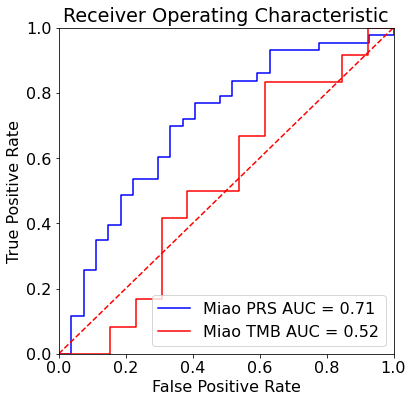

In [317]:
markers_miao_TMB=markers[markers["study"]=="miao"].dropna()
markers_miao=markers[markers["study"]=="miao"]
markers_miao_TMB.shape

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(markers_miao["pheno"],markers_miao["LASSO_burden"],pos_label=2)
roc_auc = metrics.auc(fpr, tpr)

fpr1, tpr1, threshold1 = metrics.roc_curve(markers_miao_TMB["pheno"],markers_miao_TMB["CTLA4"],pos_label=2)
roc_auc1 = metrics.auc(fpr1, tpr1)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'Miao PRS AUC = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'b', label = 'Miao TMB AUC = %0.2f' % roc_auc1,color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/Miao_TMB_vs_PRS_AUC_plot.pdf")
plt.show()


In [169]:
results=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/r2.results.csv")

In [170]:
results=results[results["Unnamed: 0"].str.contains("McFadden")]
results=results[~results["Unnamed: 0"].str.contains("Adj")]

In [171]:
results=results.pivot(index="study",columns="model",values="r2").fillna(0)

In [172]:
results=results[results.index.isin(["miao"])]
results=results.reset_index()

In [173]:
results=pd.melt(results,id_vars=["study"],value_vars=["TMB","TMB/PD1/PDL1/CTLA4","TMB/PD1/PDL1/CTLA4+germline","germline PRS only"])

In [183]:
results=results.reindex([2,3,1,0])

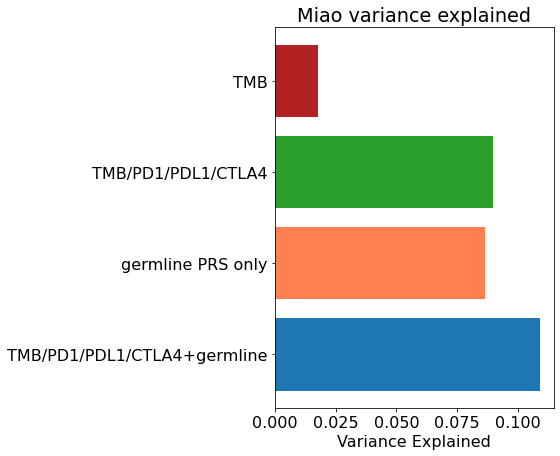

In [315]:
fig = plt.figure(figsize =(5, 7))

plt.rcParams.update({'font.size': 16})
plt.autolayout : True
# Horizontal Bar Plot
plt.barh(results["model"], results["value"],color=["tab:blue","coral","tab:green","firebrick"])
plt.xlabel("Variance Explained")
# Show Plot
plt.title("Miao variance explained")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/Miao_r2.pdf",bbox_inches = "tight")
plt.show()


